# FIFA2020 Mini-project

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [2]:
#Function to import all the csv data from the dir you are in
def import_from_dir(current_dir):
    files_lst = os.listdir(current_dir)
    df = pd.DataFrame()
    for file in files_lst:
        if file.endswith('.csv'):
            #attaching an empty dataframe to the df that wer read
            data = pd.read_csv(current_dir + file)
            df = pd.concat([df, data])
            df = df.drop_duplicates()
    return df

In [42]:
current_dir = './'
files_lst = os.listdir(current_dir)
#display(files_lst)
fifa_df=pd.read_csv(current_dir + files_lst[2]).set_index('ID', drop=True)
uefa_df=pd.read_csv(current_dir + files_lst[0],sep=';',decimal=',',na_values="-")

## Data cleaning

In [43]:
def col_names_std(df):
    import pandas as pd
    import numpy as np
    df.columns = [df.columns[i].lower().replace(' ','_') for i in range(len(df.columns))]
    return df

fifa_df=col_names_std(fifa_df)
uefa_df=col_names_std(uefa_df).rename({'país': 'nationality'}, axis=1).set_index('pos', drop=True)
display(fifa_df.head())
uefa_df.head()

,name,age,ova,nationality,club,bov,bp,position,player_photo,club_logo,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,gender
ID,,,,,,,,,,,,,,,,,,,,,
2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,https://cdn.sofifa.com/teams/55/light_60.png,...,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,https://cdn.sofifa.com/teams/2013/light_60.png,...,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,https://cdn.sofifa.com/teams/1800/light_60.png,...,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,https://cdn.sofifa.com/teams/106/light_60.png,...,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,https://cdn.sofifa.com/teams/101146/light_60.png,...,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male


,club,nationality,15/16,16/17,17/18,18/19,19/20,pts,fed
pos,,,,,,,,,
1,FC Bayern München,GER,22.0,29.0,20.0,36.0,27.0,134.0,14.714
2,Real Madrid CF,ESP,33.0,32.0,19.0,17.0,26.0,127.0,19.571
3,Manchester City FC,ENG,18.0,22.0,25.0,25.0,35.0,125.0,20.113
4,FC Barcelona,ESP,23.0,25.0,30.0,24.0,20.0,122.0,19.571
5,Juventus,ITA,33.0,23.0,21.0,22.0,21.0,120.0,15.087


In [14]:
fifa_df.info()
fifa_df.isna().sum().value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17125 entries, 2 to 259105
Columns: 106 entries, name to gender
dtypes: float64(10), int64(44), object(52)
memory usage: 14.0+ MB


0        89
58        8
7         2
23        2
89        2
413       1
423       1
16215     1
dtype: int64

### Decision: Drop rows with NaN from fifa_df
There are too many rows with at least 1 NaN. Dropping all NaNs will reduce the DF too much.
We decide to first keep those columns that are relevant for the analysis.

In [33]:
##We select those FIFA attributes that are relevant for the model.

#The categories can be found here:
#https://fifauteam.com/fifa-20-attributes-guide/

#From all the categories, we select as 'offensive' those attributes corresponding to Pace, Dribbling, Shooting and Physical.

#The defensive categories are Defending and Passing.

#We also include the best position (bp) in the model

general=['name','age','club','bp']

offensive=['acceleration','sprint_speed','agility','balance','ball_control','composure','dribbling',
                 'reactions','finishing','long_shots', 'penalties','positioning','shot_power','volleys', 'aggression',
                 'jumping','stamina','strength']
defensive=['heading_accuracy', 'interceptions', 'marking', 'sliding_tackle', 'standing_tackle', 'crossing','curve','long_passing', 'short_passing','vision']

In [34]:
fifa_df_clean=fifa_df[(general+offensive+defensive)]
fifa_df_clean

,name,age,club,bp,acceleration,sprint_speed,agility,balance,ball_control,composure,...,heading_accuracy,interceptions,marking,sliding_tackle,standing_tackle,crossing,curve,long_passing,short_passing,vision
ID,,,,,,,,,,,,,,,,,,,,,
2,G. Pasquale,33,Udinese,LWB,68,74,68.0,68.0,71,NaN,...,59,69.0,70,69.0,69,75,65.0,69,71,66.0
16,Luis García,37,KAS Eupen,CM,56,50,62.0,72.0,71,79.0,...,61,71.0,70,40.0,43,68,79.0,71,76,73.0
27,J. Cole,33,Coventry City,CAM,48,42,71.0,75.0,78,NaN,...,41,39.0,35,30.0,34,80,84.0,69,77,74.0
36,D. Yorke,36,Sunderland,ST,59,62,NaN,NaN,77,NaN,...,60,70.0,34,NaN,41,54,NaN,64,80,NaN
41,Iniesta,36,Vissel Kobe,CAM,61,56,79.0,75.0,90,89.0,...,54,70.0,68,56.0,57,75,80.0,83,90,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259088,A. Medioub,22,CD Tondela,CB,52,55,46.0,42.0,56,46.0,...,66,58.0,61,66.0,71,35,26.0,34,47,29.0
259090,W. Rickard,18,Burnley,CAM,61,63,52.0,68.0,54,46.0,...,50,50.0,34,56.0,42,50,42.0,61,64,53.0
259091,C. Barrett,18,Burnley,RB,66,61,54.0,68.0,47,43.0,...,53,55.0,55,54.0,54,55,43.0,36,42,45.0


In [35]:
fifa_df_clean.dropna(axis=0, how='any', inplace=True)
fifa_df_clean

,name,age,club,bp,acceleration,sprint_speed,agility,balance,ball_control,composure,...,heading_accuracy,interceptions,marking,sliding_tackle,standing_tackle,crossing,curve,long_passing,short_passing,vision
ID,,,,,,,,,,,,,,,,,,,,,
16,Luis García,37,KAS Eupen,CM,56,50,62.0,72.0,71,79.0,...,61,71.0,70,40.0,43,68,79.0,71,76,73.0
41,Iniesta,36,Vissel Kobe,CAM,61,56,79.0,75.0,90,89.0,...,54,70.0,68,56.0,57,75,80.0,83,90,93.0
80,E. Belözoğlu,38,Fenerbahçe SK,CM,54,36,67.0,81.0,81,80.0,...,43,62.0,65,60.0,65,80,83.0,85,84,85.0
330,R. Keane,35,LA Galaxy,CF,69,68,77.0,83.0,84,86.0,...,63,34.0,28,17.0,26,68,82.0,63,81,82.0
1179,G. Buffon,42,Juventus,GK,37,30,55.0,49.0,28,70.0,...,13,28.0,13,11.0,11,13,20.0,35,37,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259088,A. Medioub,22,CD Tondela,CB,52,55,46.0,42.0,56,46.0,...,66,58.0,61,66.0,71,35,26.0,34,47,29.0
259090,W. Rickard,18,Burnley,CAM,61,63,52.0,68.0,54,46.0,...,50,50.0,34,56.0,42,50,42.0,61,64,53.0
259091,C. Barrett,18,Burnley,RB,66,61,54.0,68.0,47,43.0,...,53,55.0,55,54.0,54,55,43.0,36,42,45.0


In [44]:
uefa_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, 1  to 428 
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   club         428 non-null    object 
 1   nationality  428 non-null    object 
 2   15/16        232 non-null    float64
 3   16/17        236 non-null    float64
 4   17/18        237 non-null    float64
 5   18/19        237 non-null    float64
 6   19/20        237 non-null    float64
 7    pts         428 non-null    float64
 8    fed         428 non-null    float64
dtypes: float64(7), object(2)
memory usage: 33.4+ KB


### We will only keep the values for the 19/20 season for the model. In fact, those will be the ones we use as target. So, we will have a DF with club, nationality and 19/20.

In [47]:
uefa_df_clean=uefa_df[['club', 'nationality', '19/20']].dropna(axis=0, how='any')
uefa_df_clean

,club,nationality,19/20
pos,,,
1,FC Bayern München,GER,27.0
2,Real Madrid CF,ESP,26.0
3,Manchester City FC,ENG,35.0
4,FC Barcelona,ESP,20.0
5,Juventus,ITA,21.0
...,...,...,...
413,KF Gjilani,KOS,1.0
415,Víkingur Reykjavík,ISL,1.0
415,Paide Linnameeskond,EST,1.0


## EDA

In [36]:
summary = fifa_df_clean.describe().T
summary['iqr'] = summary['75%']-summary['25%'] #addition of the iqr -inter quantile range- column
summary = summary.apply(lambda x: round(x, 2))
display(summary)

,count,mean,std,min,25%,50%,75%,max,iqr
age,16687.0,25.15,4.85,16.0,21.0,25.0,29.0,53.0,8.0
acceleration,16687.0,65.51,14.65,12.0,58.5,68.0,75.0,97.0,16.5
sprint_speed,16687.0,65.51,14.42,11.0,59.0,68.0,75.0,96.0,16.0
agility,16687.0,64.64,14.38,14.0,57.0,67.0,75.0,96.0,18.0
balance,16687.0,64.71,14.03,17.0,57.0,67.0,75.0,97.0,18.0
ball_control,16687.0,60.55,15.85,5.0,57.0,64.0,70.0,96.0,13.0
composure,16687.0,59.94,11.75,12.0,53.0,61.0,68.0,96.0,15.0
dribbling,16687.0,57.80,18.05,5.0,53.0,63.0,70.0,96.0,17.0
reactions,16687.0,62.84,8.99,24.0,57.0,63.0,69.0,95.0,12.0
finishing,16687.0,47.87,19.38,3.0,33.0,52.0,63.0,95.0,30.0


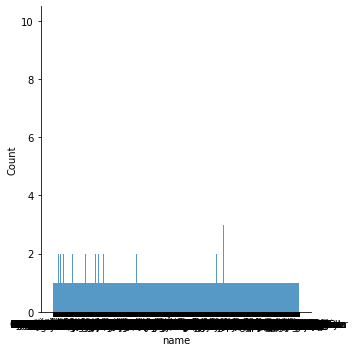

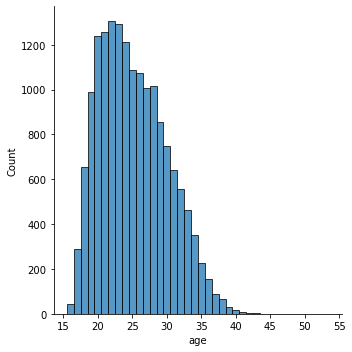

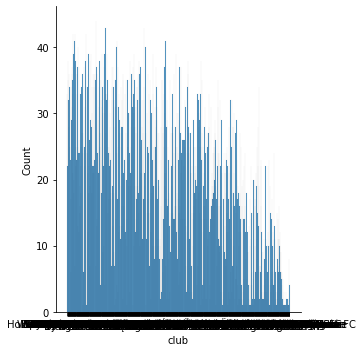

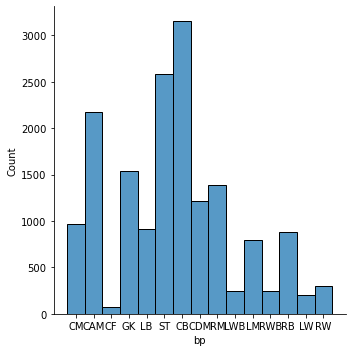

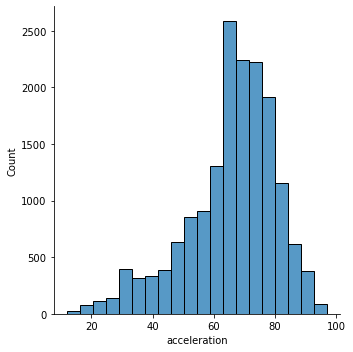

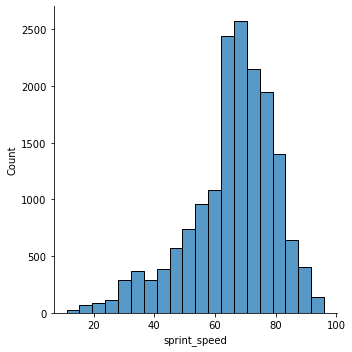

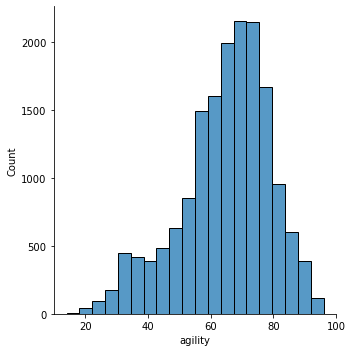

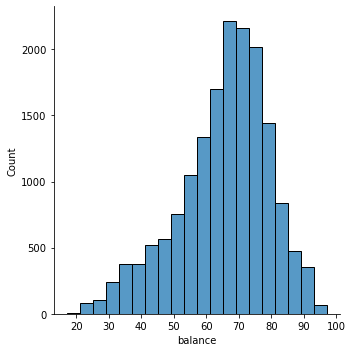

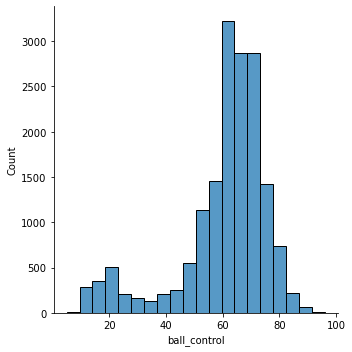

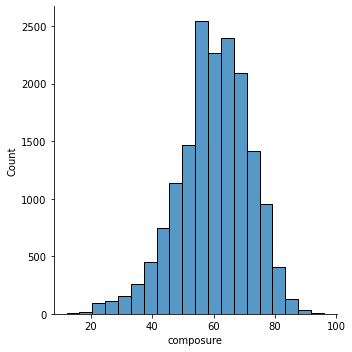

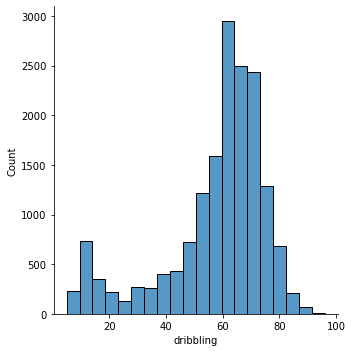

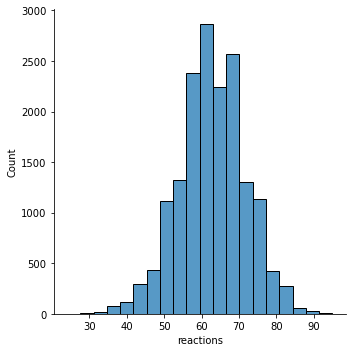

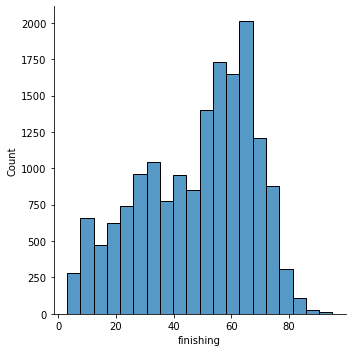

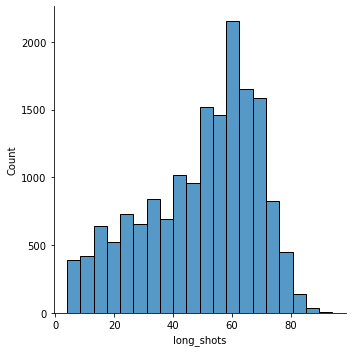

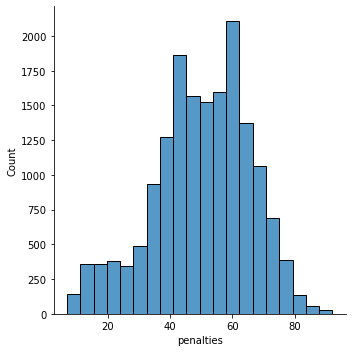

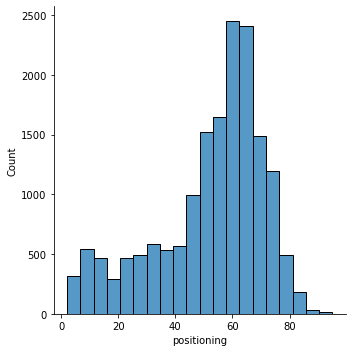

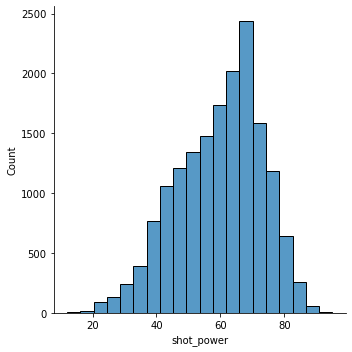

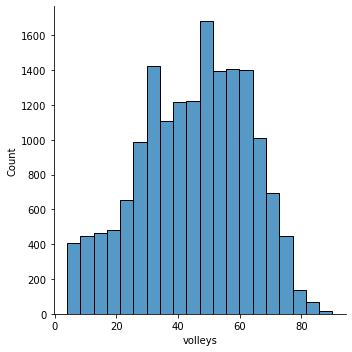

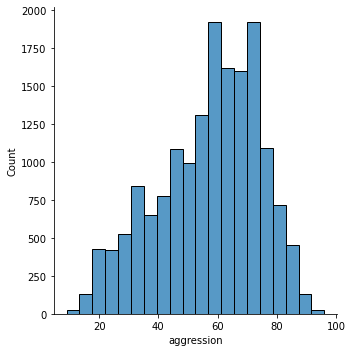

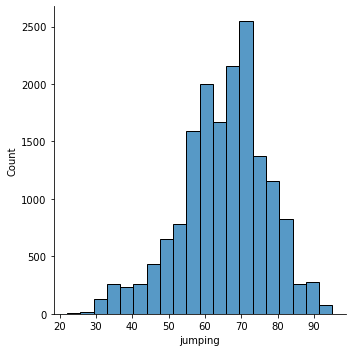

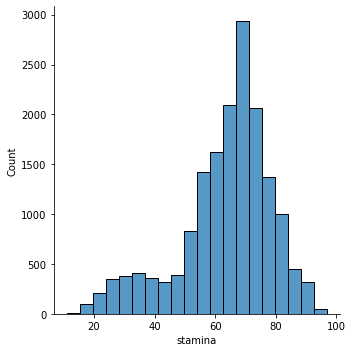

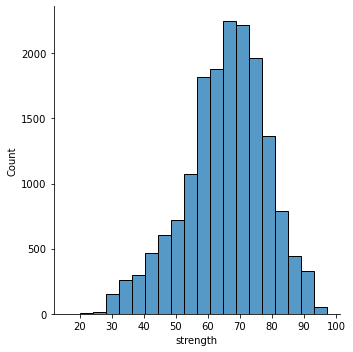

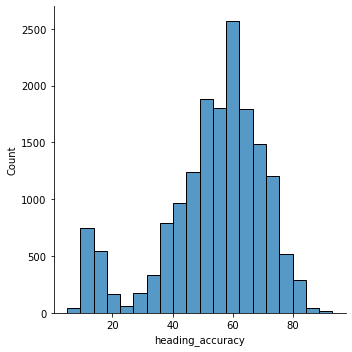

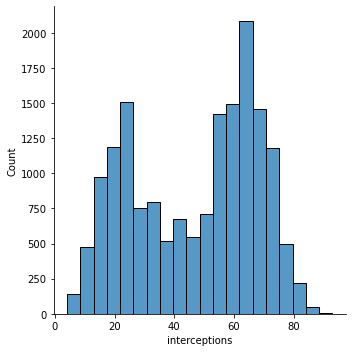

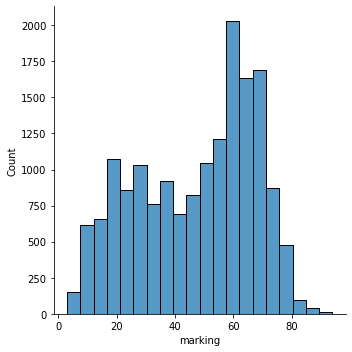

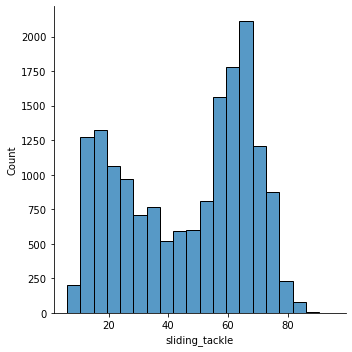

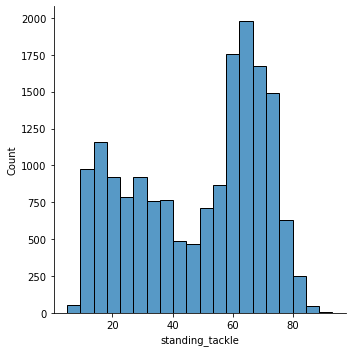

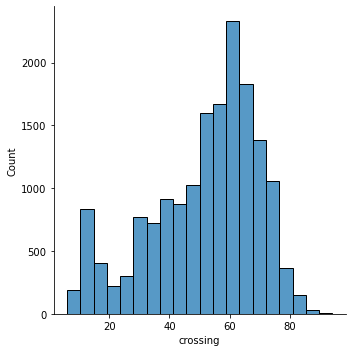

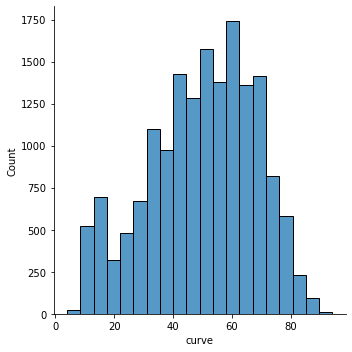

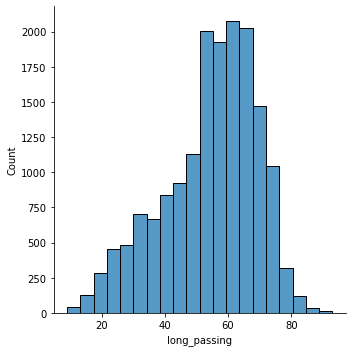

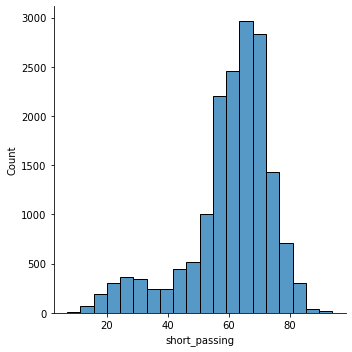

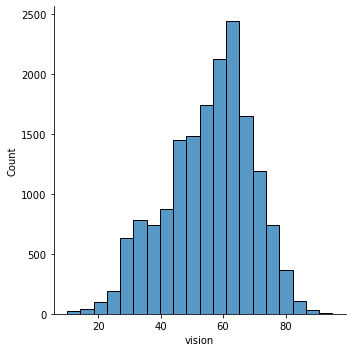

In [52]:
#numerical=offensive+defensive

#for column in fifa_df_clean.drop.columns:
 #   if column in numerical:
  #      sns.displot(fifa_df_clean, x=column, bins=20)
   # else:
    #    sns.displot(fifa_df_clean, x=column, discrete=True)